In [1]:
import pandas as pd
import numpy as np

from collections import Counter
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, Concatenate
from tensorflow.keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D, LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal 
import tensorflow.keras.backend as K
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import xgboost as xgb
from packaging import version
import sklearn
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
print(tf.__version__)
print(tf.executing_eagerly())
tf.config.run_functions_eagerly(True)

df = pd.read_excel("/home/jui/thesis-code/data/credit_card_clients.xls")
df['default payment next month'].value_counts()
print(df.shape)

2025-03-17 12:59:25.354870: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742241565.850986   50933 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742241565.971679   50933 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-17 12:59:26.853164: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.18.0
True
(30000, 25)


In [3]:
from raimitigations.dataprocessing import Rebalance  

df['EDUCATION'] = df['EDUCATION'].replace({1: 1, 2: 1, 3: 2, 4: 3})

bins = [0, 25, 35, 45, 55, 70, float('inf')]  # Define bin edges
labels = [1, 2, 3, 4, 5, 6]  # Assign category labels

df['AGE'] = pd.cut(df['AGE'], bins=bins, labels=labels, right=False).astype(int)

df['MARRIAGE'] = df['MARRIAGE'].replace({0: 3})

df = df.drop(columns=['ID'])
df = df.drop(columns=['LIMIT_BAL'])

# Count occurrences of each unique value across all PAY_* columns
value_counts = df[['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']].stack().value_counts()

# List of columns to modify
pay_columns = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

# Replace -2 with -1
df[pay_columns] = df[pay_columns].replace({-2:-1})

rebalance = Rebalance(
				df=df,
				rebalance_col='SEX',
				k_neighbors=5,
				verbose=False
			)
df = rebalance.fit_resample()
print(df['SEX'].value_counts())

/home/jui/.pyenv/versions/3.10.12/envs/myenv/lib/python3.10/site-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(


2    18112
1    18112
Name: SEX, dtype: int64


In [4]:
def split_label(dataset, target_feature):
    X = dataset.drop([target_feature], axis=1)
    y = dataset[[target_feature]]
    return X, y

# Handle different scikit-learn versions for OneHotEncoder parameters
if version.parse(sklearn.__version__) < version.parse('1.2'):
    ohe_params = {"sparse": False}
else:
    ohe_params = {"sparse_output": False}

def create_classification_pipeline(X,y):
    pipe_cfg = {
        'num_cols': X.select_dtypes(include=['int64', 'float64', 'float32']).columns.tolist(),
        'cat_cols': X.select_dtypes(include=['object']).columns.tolist(),
    }
    
    num_pipe = Pipeline([ 
        ('num_imputer', SimpleImputer(strategy='median')),
        ('num_scaler', StandardScaler())
    ])
    cat_pipe = Pipeline([
        ('cat_imputer', SimpleImputer(strategy='constant', fill_value='?')),
        ('cat_encoder', OneHotEncoder(handle_unknown='ignore', **ohe_params))
    ])
    feat_pipe = ColumnTransformer([
        ('num_pipe', num_pipe, pipe_cfg['num_cols']),
        ('cat_pipe', cat_pipe, pipe_cfg['cat_cols'])
    ])

    # Calculate scale_pos_weight
    negative_count = np.sum(y == 0)
    positive_count = np.sum(y == 1)
    scale_pos_weight = negative_count / positive_count
    print(scale_pos_weight)
    
    # Using XGBClassifier with Regularization, Learning Rate, and Eval Metrics
    xgb_model = xgb.XGBClassifier(
        tree_method='hist',  # Fast histogram-based training
        random_state=10,
        n_jobs=-1,  # Use all CPU cores
        learning_rate=0.16,  # Controls step size
        reg_lambda=1.1,  # L2 regularization (weight decay)
        eval_metric='logloss',
        objective='binary:logistic',  # Logarithmic loss for classification
        n_estimators=125,
        #scale_pos_weight = scale_pos_weight,
    )

    pipeline = Pipeline(steps=[('preprocessor', feat_pipe),
                               ('model', xgb_model)])

    return pipeline

4.057334326135518
PR-AUC: 0.579215997620242
Model Accuracy: 0.8429
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.96      0.91      7308
           1       0.67      0.36      0.47      1748

    accuracy                           0.84      9056
   macro avg       0.77      0.66      0.69      9056
weighted avg       0.83      0.84      0.82      9056


Final Training Log Loss: 0.2942
Final Test Log Loss: 0.3944


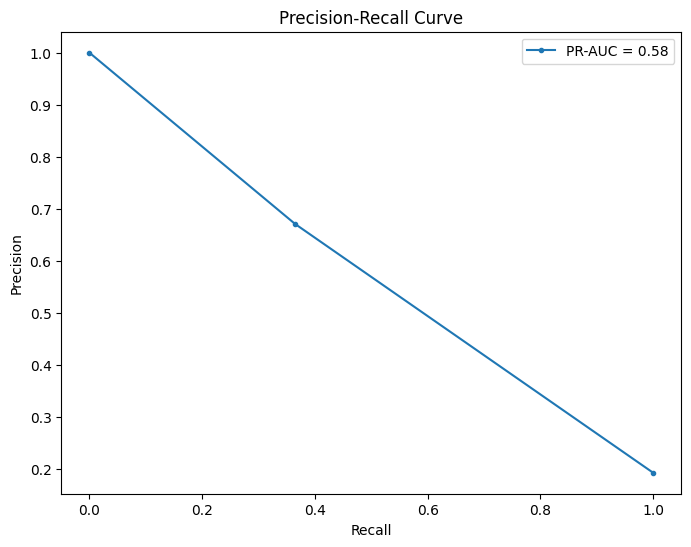

In [5]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

target_feature = 'default payment next month'

# Split data into features and target
X, y = split_label(df, target_feature)

# Split data into train and test sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=40)

y_train = y_train.squeeze() 

features = X_train.columns.tolist()  
classes = np.unique(y_train).tolist() 

# Create the classification pipeline
pipeline = create_classification_pipeline(X_train, y_train)

# Fit the preprocessor separately to extract feature names
pipeline.named_steps['preprocessor'].fit(X_train)

# Extract transformed feature names safely
if hasattr(pipeline.named_steps['preprocessor'], "get_feature_names_out"):
    feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
else:
    # Manually construct feature names (for older sklearn versions)
    num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
    cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()
    feature_names = num_cols + cat_cols  # Not perfect, but works if get_feature_names_out() is missing

# Convert y_train and y_test to NumPy arrays
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

# Extract XGBClassifier separately and fit with eval_set
xgb_model = pipeline.named_steps['model']
model = xgb_model.fit(pipeline.named_steps['preprocessor'].transform(X_train), y_train, 
              eval_set=[(pipeline.named_steps['preprocessor'].transform(X_train), y_train),
                        (pipeline.named_steps['preprocessor'].transform(X_test), y_test)], verbose=False)

# Make predictions
y_pred = model.predict(pipeline.named_steps['preprocessor'].transform(X_test))

# Compute Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

# Calculate PR-AUC (area under the Precision-Recall curve)
pr_auc = auc(recall, precision)

print("PR-AUC:", pr_auc)

# Compute accuracy and classification report
accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Model Accuracy: {accuracy:.4f}")
print(f"Classification Report:\n{class_report}\n")

# Extract evaluation results
evals_result = xgb_model.evals_result()

# Get the final log loss for training and testing
train_log_loss = evals_result['validation_0']['logloss'][-1]
test_log_loss = evals_result['validation_1']['logloss'][-1]

# Print the final log loss values for both training and validation
print(f"Final Training Log Loss: {train_log_loss:.4f}")
print(f"Final Test Log Loss: {test_log_loss:.4f}")

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label=f'PR-AUC = {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()